In [1]:
import cv2
from torchvision.utils import make_grid
from torch import as_tensor
import numpy as np
from matplotlib import pyplot as plt

from vision_detector import VisionDetector
from settings import MONTOR_HEIGHT, MONITOR_WIDTH, DATA_DIR, DATASETS_DIR

In [2]:
MINIMAP_DATASET_DIR = DATASETS_DIR / 'minimap'

## Adjust crop

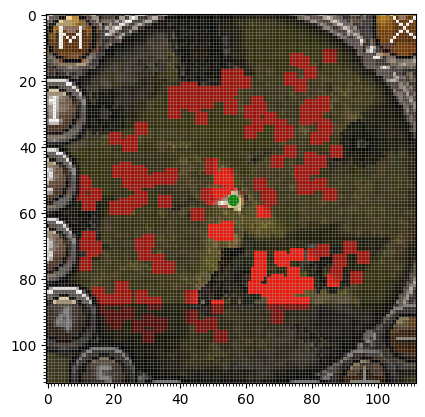

In [3]:
MINIMAP_SIZE = 112
MINIMAP_TOP_ANCHOR = 12
MINMAP_LEFT_ANCHOR = 12

minimap_bbox = (
    MONITOR_WIDTH - MINIMAP_SIZE - MINMAP_LEFT_ANCHOR,  # x
    MINIMAP_TOP_ANCHOR,  # y
    MINIMAP_SIZE,  # width
    MINIMAP_SIZE  # height
)

src_frame = cv2.imread(str(MINIMAP_DATASET_DIR / "raw" / "0219_194218.jpg"), cv2.IMREAD_COLOR)
src_frame = cv2.cvtColor(src_frame, cv2.COLOR_BGR2RGB)
frame_w, frame_h = src_frame.shape[:2]

cropped_img = VisionDetector.crop_bbox(src_frame, *minimap_bbox)

plt.imshow(cropped_img)

ax = plt.gca()
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # Set x minor ticks at 0.1 intervals
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set y minor ticks at 0.05 intervals

minimap_center = (MINIMAP_SIZE // 2, MINIMAP_SIZE // 2)
plt.scatter(*minimap_center, c='green', s=50)

plt.grid(which='both', alpha=0.3)
plt.show()

## Crop minimap images and save to disk

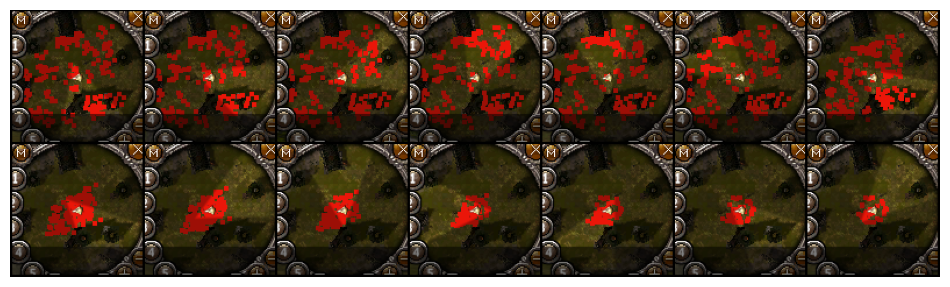

In [4]:
cropped_imgs_tensors = []
for img_fpath in MINIMAP_DATASET_DIR.glob("raw/*.jpg"):
    img = cv2.imread(str(img_fpath), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = VisionDetector.crop_bbox(img, *minimap_bbox)
    cv2.imwrite(str(MINIMAP_DATASET_DIR / "cropped" / img_fpath.name), cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))
    img_tensor = as_tensor(cropped_img).permute(2, 0, 1) / 255.0
    cropped_imgs_tensors.append(img_tensor)

cropped_grid = make_grid(cropped_imgs_tensors, nrow=7)

# Convert grid to numpy array and display it
grid_np = cropped_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(12, 4))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

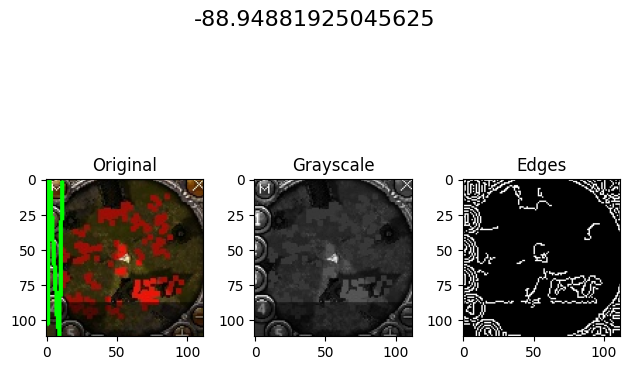

In [5]:
for img_fpath in MINIMAP_DATASET_DIR.glob("cropped/*.jpg"):
    image = cv2.imread(str(img_fpath))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    edges = cv2.Canny(gray_image, 100, 200)

    # Use Hough transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=250)

    # Initialize the angle
    angle = None

    # Draw lines on the image and calculate the angle
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Calculate the angle of the line
            angle = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))

    # Show the original, grayscale, edge, and line image
    fig = plt.figure()
    plt.subplot(131), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(132), plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale')
    plt.subplot(133), plt.imshow(edges, cmap='gray'), plt.title('Edges')
    fig.suptitle(f"{angle}", fontsize=16)
    plt.tight_layout()
    plt.show()

    break


## Adjust parameters

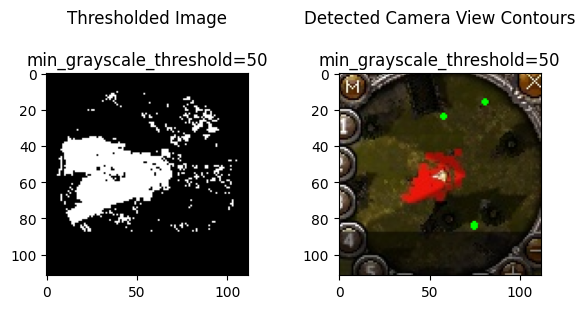

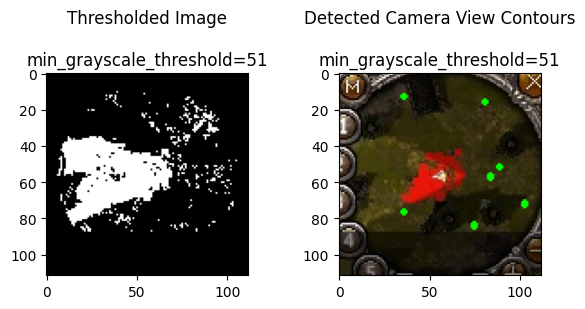

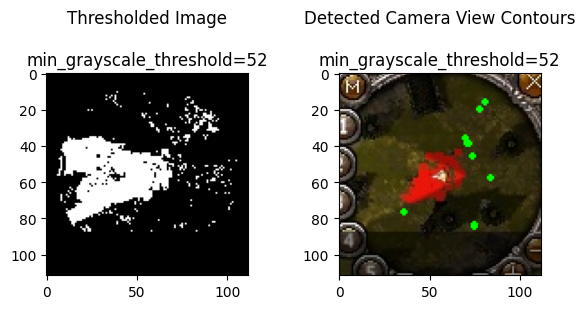

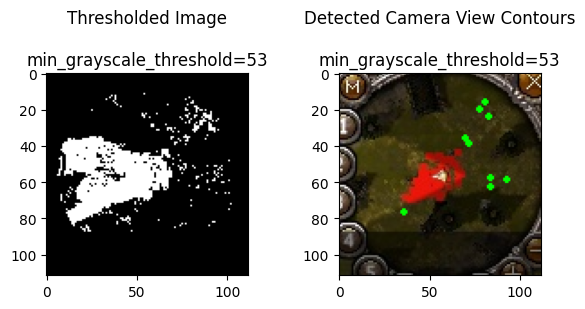

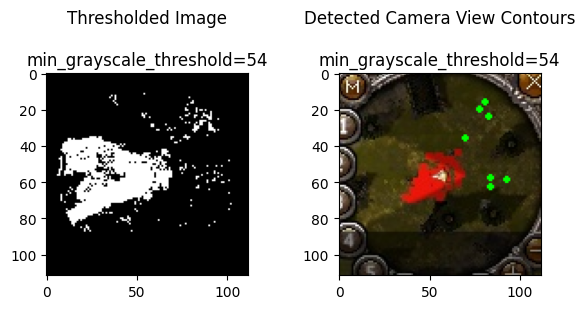

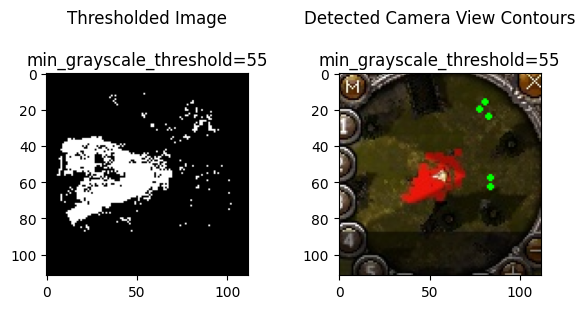

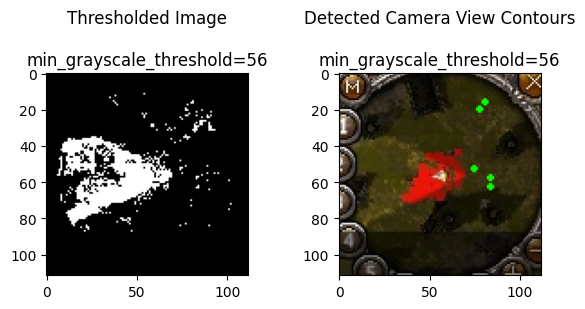

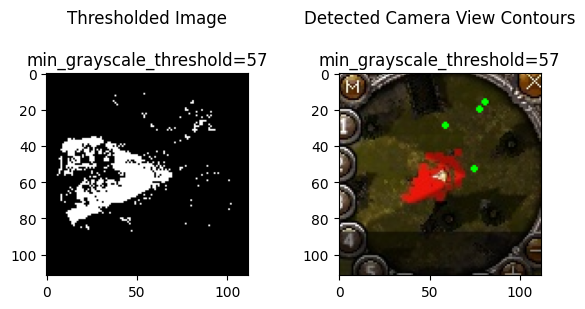

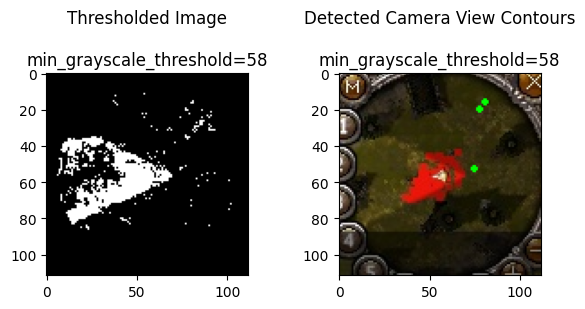

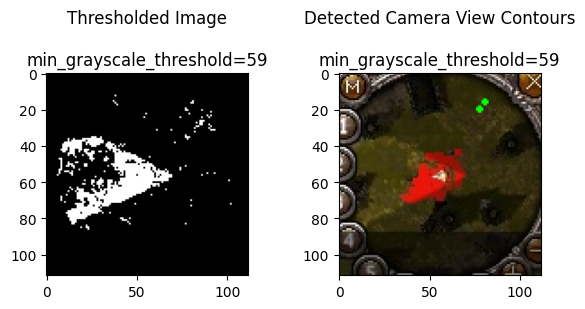

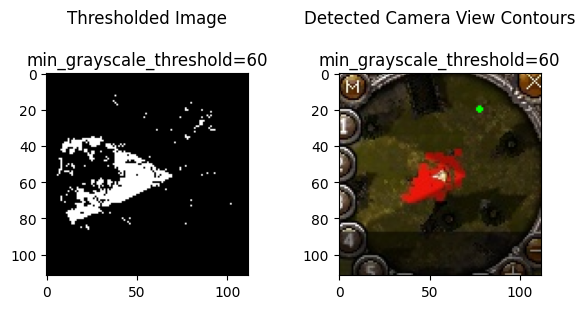

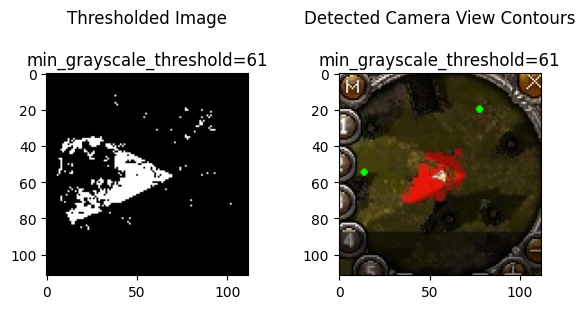

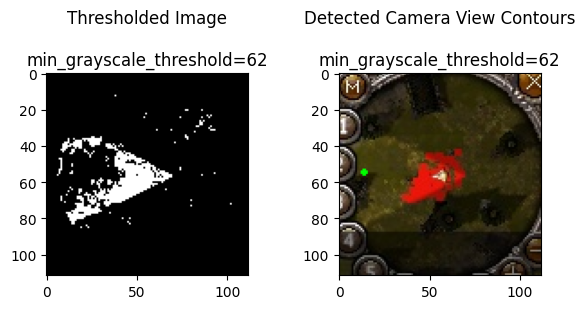

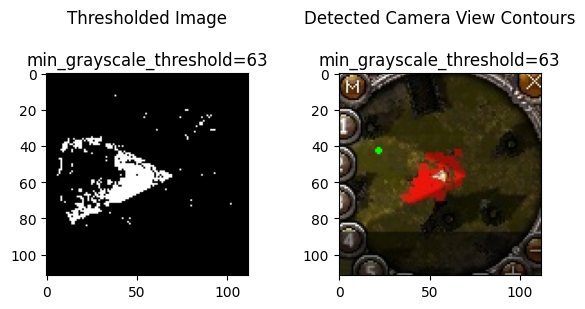

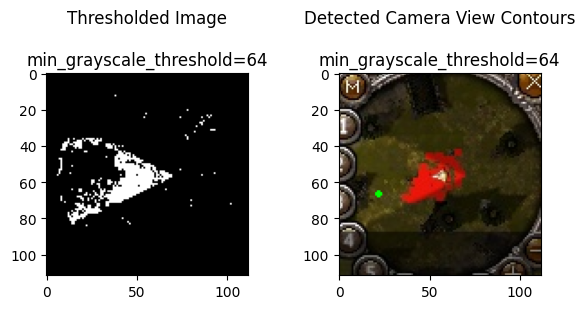

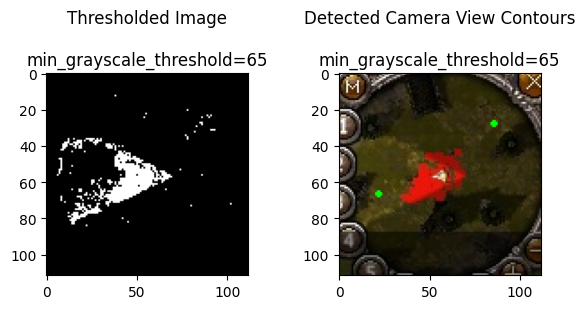

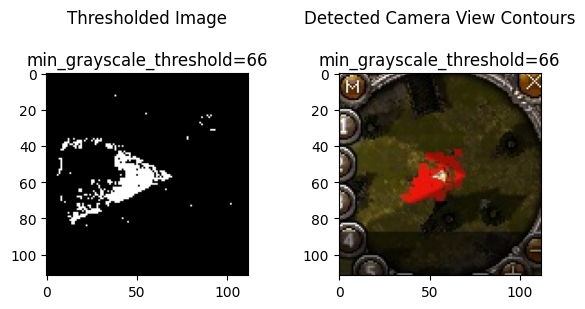

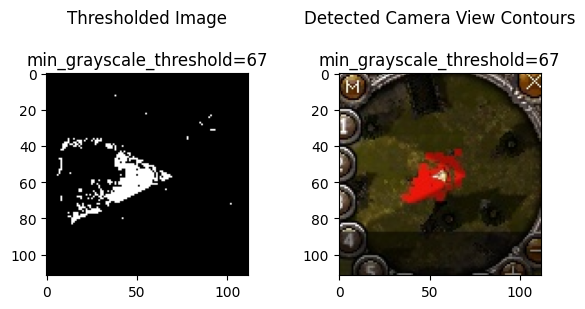

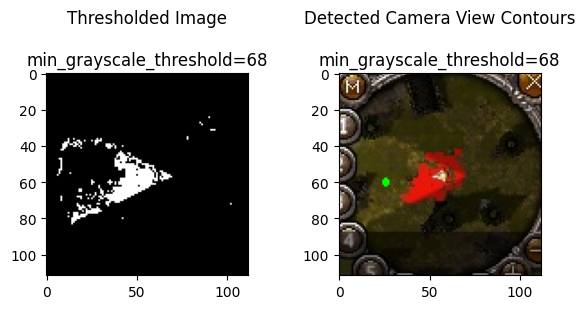

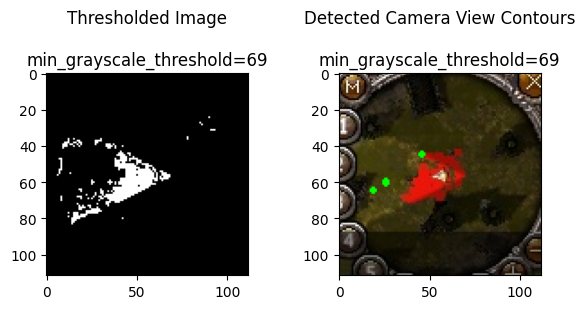

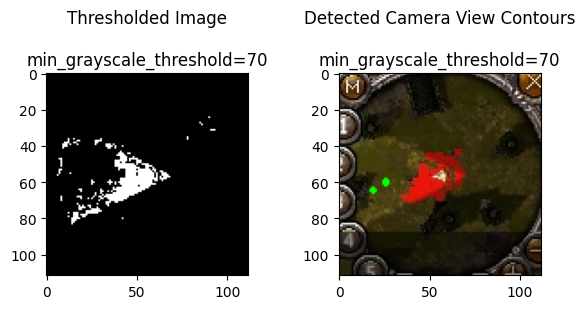

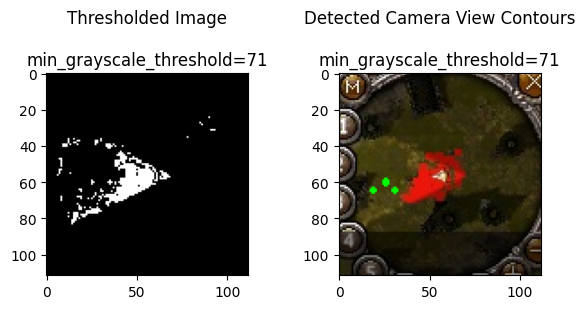

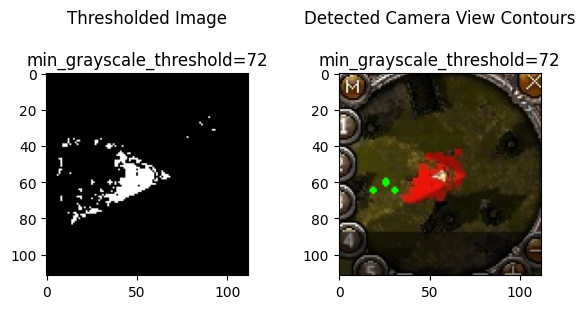

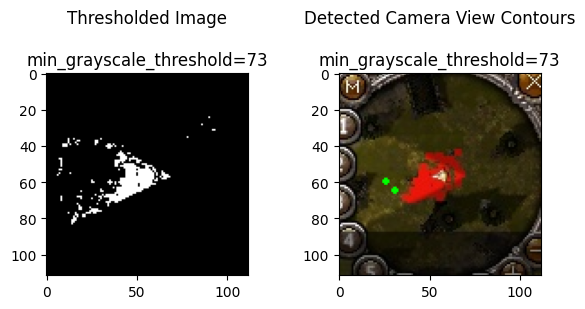

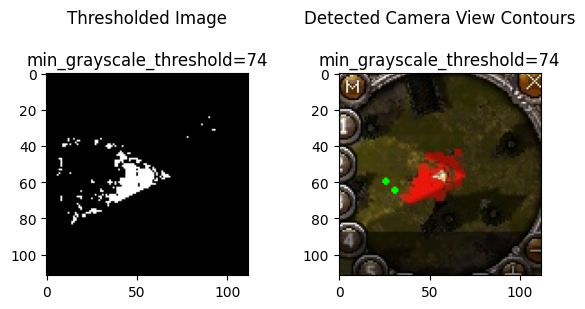

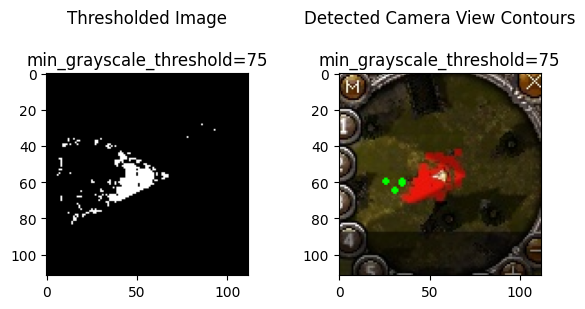

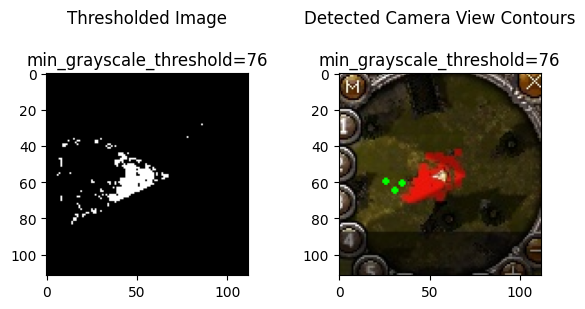

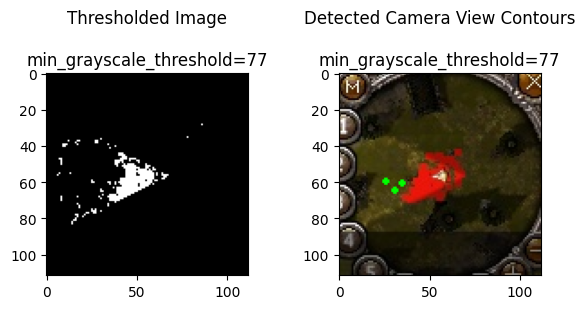

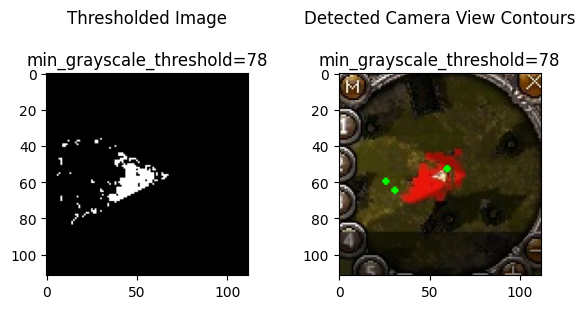

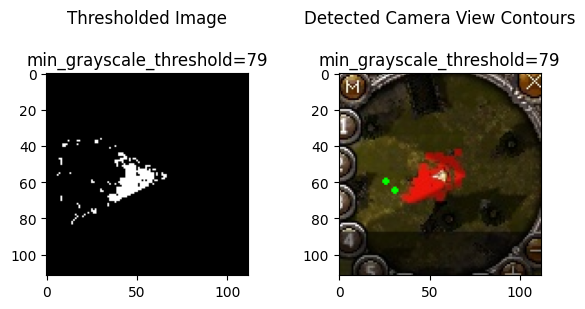

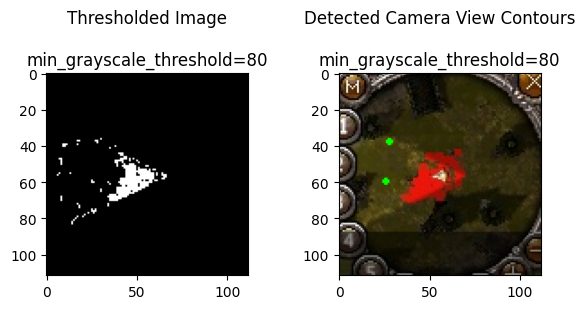

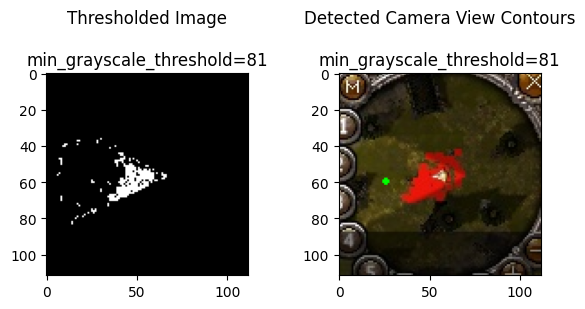

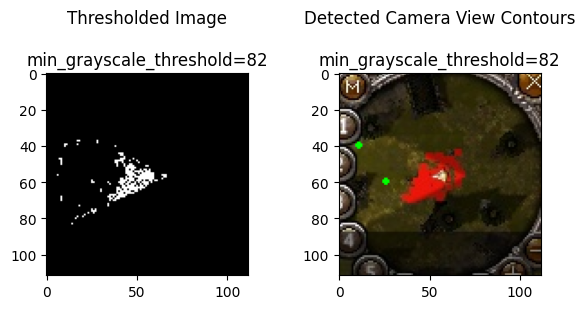

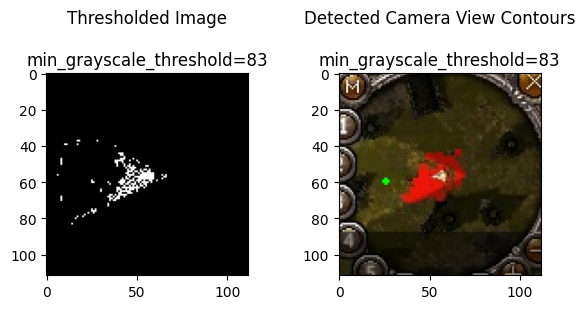

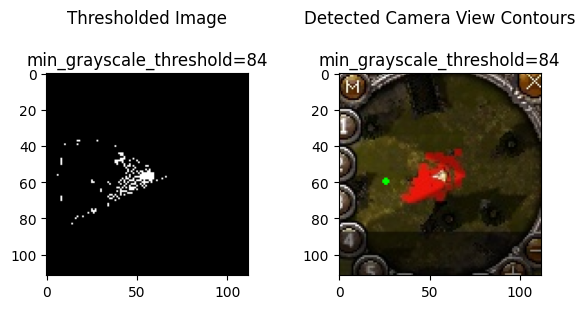

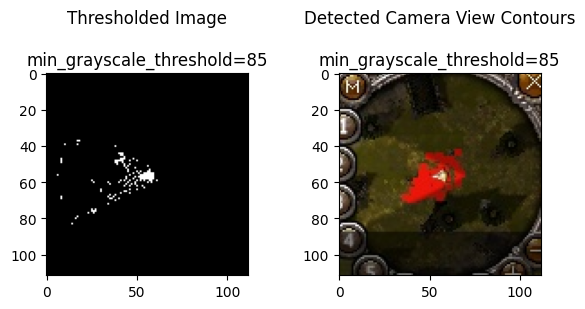

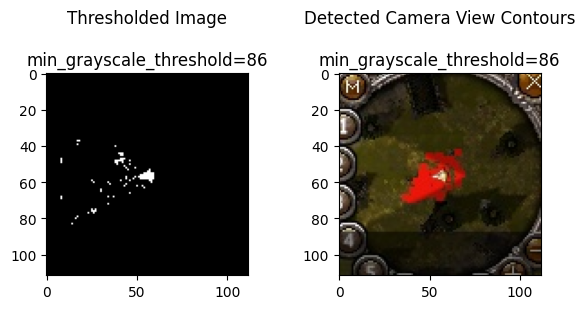

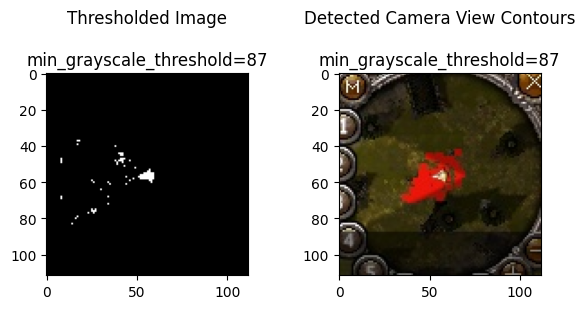

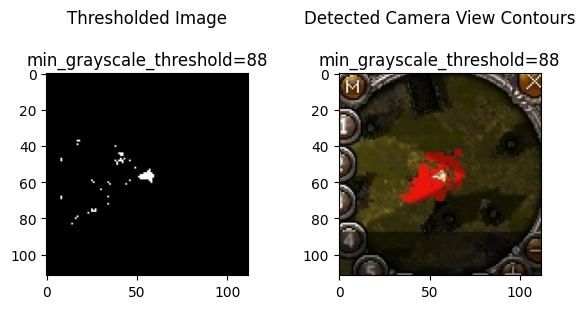

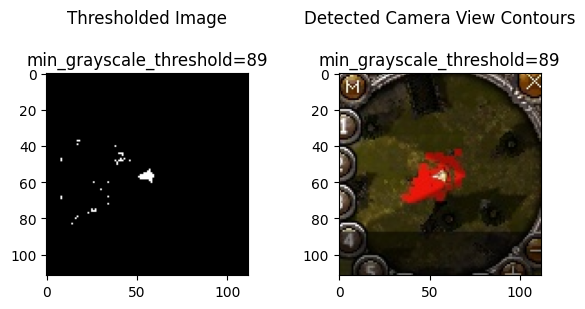

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# image_path = r'C:\Users\jedrz\OneDrive\Documents\metin2_vision_bot\data\datasets\minimap\cropped\0219_194218.jpg'
# image_path = r'C:\Users\jedrz\OneDrive\Documents\metin2_vision_bot\data\datasets\minimap\cropped\0219_194231.jpg'
image_path = r'C:\Users\jedrz\OneDrive\Documents\metin2_vision_bot\data\datasets\minimap\cropped\0219_194236.jpg'

ROI_MASK_RADIUS = 50

min_grayscale_threshold_values = np.arange(50, 90, 1)
for min_grayscale_threshold in min_grayscale_threshold_values:

    # Let's correct the process by analyzing the thresholded image to find the camera view direction without using the annotated data.

    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    height, width = gray_image.shape
    center_x, center_y = width // 2, height // 2

    # Create a circular mask with the specified radius
    circular_mask = np.zeros_like(gray_image, dtype=np.uint8)
    cv2.circle(circular_mask, (center_x, center_y), ROI_MASK_RADIUS, 255, -1)

    # Apply the circular mask to the grayscale image
    masked_gray = cv2.bitwise_and(gray_image, gray_image, mask=circular_mask)


    # Apply a threshold to isolate the lighter areas that are likely to be part of the camera view
    _, thresholded_image = cv2.threshold(masked_gray, min_grayscale_threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Approximate contours to polygons and filter out shapes that are not triangular (3 vertices)
    camera_view_contours = []
    for cnt in contours:
        # Approximate the contour to a polygon
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # If the polygon has 3 vertices, it may be the triangular camera view indicator
        if len(approx) == 3:
            camera_view_contours.append(approx)

    # Draw detected camera view contours on the image
    image_with_contours = image.copy()
    contour_color = (0, 255, 0)
    contour_thickness = 2
    cv2.drawContours(image_with_contours, camera_view_contours, -1, contour_color, contour_thickness)

    # Display the thresholded image and the image with detected camera view contours
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(thresholded_image, cmap='gray')
    plt.title(f'Thresholded Image\n\n{min_grayscale_threshold=}')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Camera View Contours\n\n{min_grayscale_threshold=}')

    # Show the plot
    plt.tight_layout()
    plt.show()


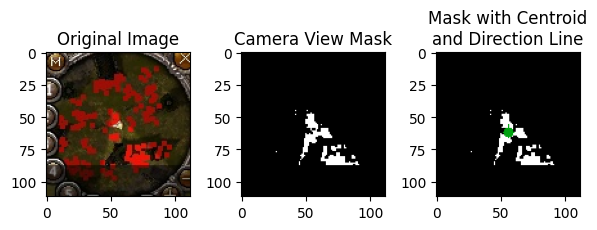

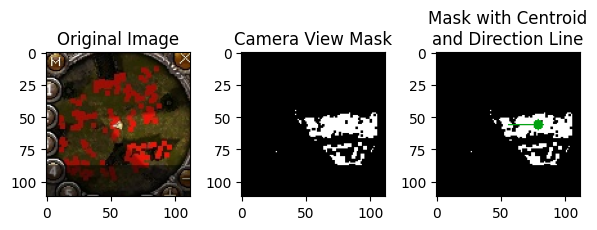

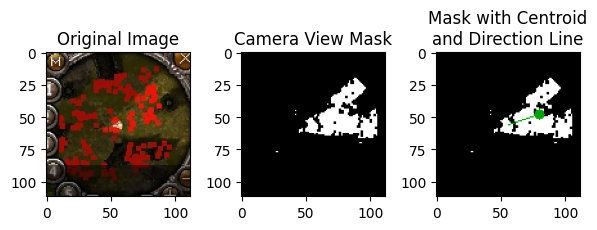

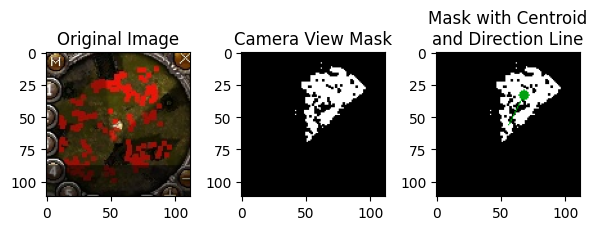

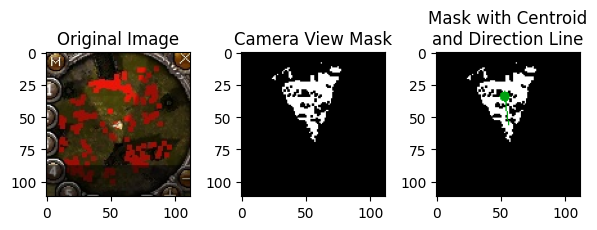

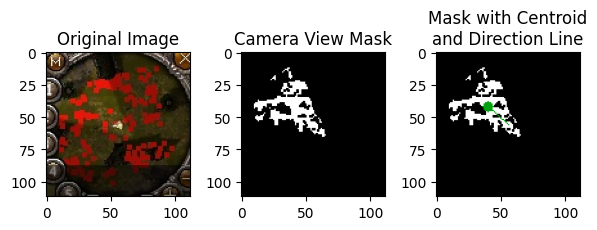

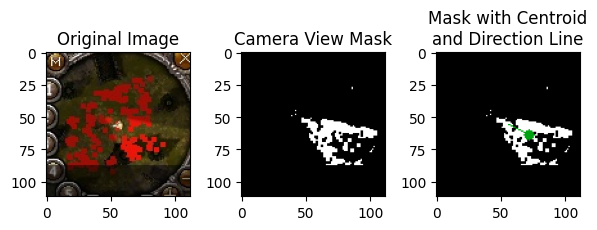

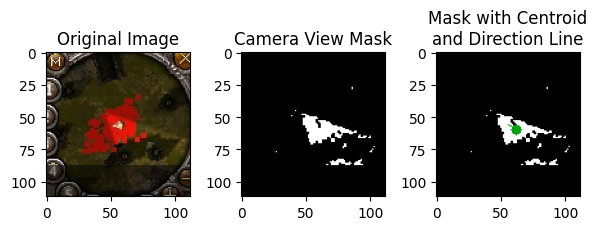

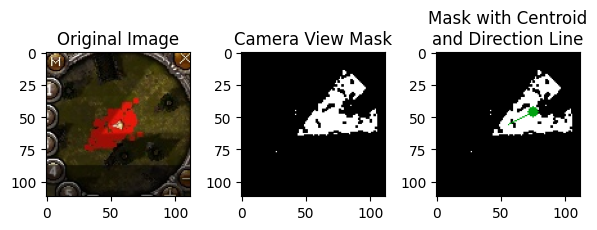

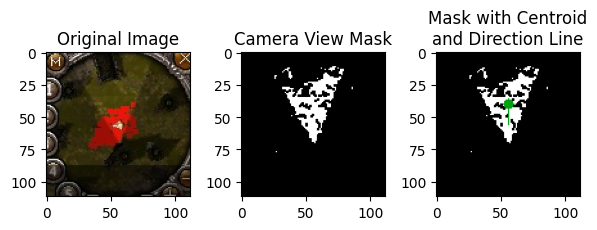

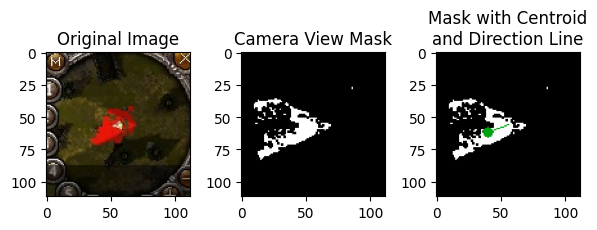

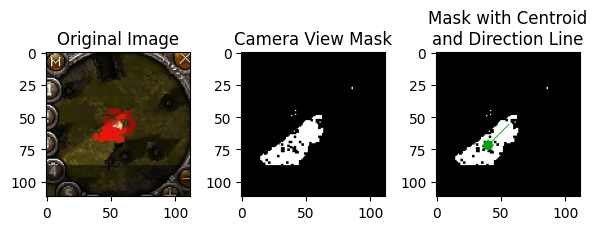

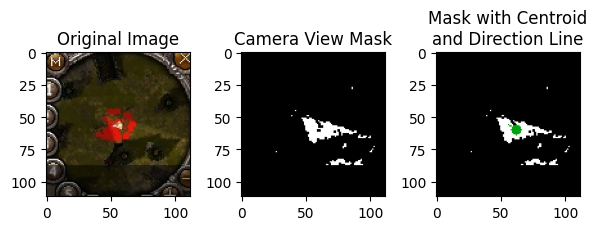

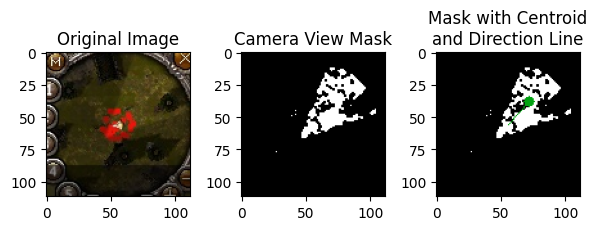

: 

In [14]:
def delete_alone_pixels(image, neighborhood_size=2):
    kernel = np.ones((neighborhood_size, neighborhood_size), np.uint8)
    return cv2.erode(image, kernel, iterations=1)


MIN_GRAYSCALE_THRESHOLD = 57


DIRECTION_MARKER_COLOR = (0, 161, 16)
DIRECTION_MARKER_RADIUS = 4
DIRECTION_LINE_COLOR = (0, 161, 16)
DIRECTION_LINE_THICKNESS = 1


for img_fpath in MINIMAP_DATASET_DIR.glob("cropped/*.jpg"):
    image = cv2.imread(str(img_fpath))
    img_center = (image.shape[1] // 2, image.shape[0] // 2)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = gray_image.shape
    center_x, center_y = width // 2, height // 2

    # Create a circular mask with the specified radius
    circular_mask = np.zeros_like(gray_image, dtype=np.uint8)
    cv2.circle(circular_mask, (center_x, center_y), ROI_MASK_RADIUS, 255, -1)

    # Apply the circular mask to the grayscale image
    masked_gray = cv2.bitwise_and(gray_image, gray_image, mask=circular_mask)

    # Apply a threshold to isolate the lighter areas that are likely to be part of the camera view
    _, camera_view_mask = cv2.threshold(masked_gray, MIN_GRAYSCALE_THRESHOLD, 255, cv2.THRESH_BINARY)
    
    # Delete alone pixels
    camera_view_mask_wthout_alone_pixels = delete_alone_pixels(camera_view_mask)


    # Find contours in the binary image
    contours, _ = cv2.findContours(camera_view_mask_wthout_alone_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour which should represent the direction
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the moments of the largest contour to find the centroid
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        # Set the centroid to the center of the image if the contour area is zero
        cX, cY = center_x, center_y
        raise ValueError("The contour area is zero!")

    # Mark the centroid point on the image
    mask_wth_direction = cv2.cvtColor(camera_view_mask_wthout_alone_pixels, cv2.COLOR_GRAY2BGR)
    cv2.circle(mask_wth_direction, (cX, cY), DIRECTION_MARKER_RADIUS, DIRECTION_MARKER_COLOR, -1)
    cv2.line(mask_wth_direction, img_center, (cX, cY), DIRECTION_LINE_COLOR, DIRECTION_LINE_THICKNESS)

    # Display the thresholded image and the image with detected camera view contours
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(camera_view_mask_wthout_alone_pixels, cmap='gray')
    plt.title(f'Camera View Mask')

    # Plot the image with the marked centroid
    plt.subplot(1, 3, 3)
    plt.imshow(mask_wth_direction, cmap='gray')
    plt.title('Mask with Centroid\nand Direction Line')

    # Show the plot
    plt.tight_layout()
    plt.show()